In [14]:
import pandas as pd
import json_handling as jh
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
folder_path = 'aob_2025/orders'

all_data = jh.load_json_objects_from_folder(folder_path)
print(f"Loaded {len(all_data)} JSON objects from {folder_path}")

dfs = jh.extract_dataframes(all_data)
    

Loaded 43800 JSON objects from aob_2025/orders


In [4]:
df_orders = dfs['orders']
df_payment_details = dfs['payment_details']
df_orderlines = dfs['orderlines']
df_shown_addons = dfs['shown_addons']
df_search_data = dfs['search_data']
df_search_orders = dfs['search_orders']
df_search_parameters = dfs['search_parameters']


In [5]:

# Merge orders with payment details
df_combined = df_orders.merge(
    df_payment_details[['order_id', 'cost', 'total_sales_price', 'paid_amount']],
    on='order_id',
    how='left',
    suffixes=('', '_payment')
)

# Merge with search data
df_combined = df_combined.merge(
    df_search_data,
    left_on='order_id',
    right_on='parent_order_id',
    how='left',
    suffixes=('', '_search')
)

# Merge with shown addons if present
if 'df_shown_addons' in locals():
    df_combined = df_combined.merge(
        df_shown_addons,
        on='order_id',
        how='left'
    )

# Convert mobile to boolean
if 'mobile' in df_combined.columns:
    df_combined['mobile'] = df_combined['mobile'].astype(bool)

# Calculate number of legs from itinerary_string
def count_itinerary_legs(itinerary):
    if pd.isna(itinerary) or itinerary == '':
        return 0
    
    if isinstance(itinerary, str):
        if ',' in itinerary:
            # Format: "FRA-LON, LON-AGP, AGP-FRA"
            return len(itinerary.split(','))
        elif '-' in itinerary:
            # Format: "FRA-LON-AGP-FRA"
            segments = itinerary.split('-')
            return len(segments) - 1 if len(segments) > 1 else 0
    
    return 0

if 'itinerary_string' in df_combined.columns:
    df_combined['num_legs'] = df_combined['itinerary_string'].apply(count_itinerary_legs)

# Process search parameters if available
if 'df_search_parameters' in locals():
    if 'rooms' in df_search_parameters.columns:
        df_search_parameters['num_rooms'] = df_search_parameters['rooms'].apply(
            lambda x: len(x) if isinstance(x, list) else 0
        )
    else:
        df_search_parameters['num_rooms'] = 0
    
    df_search_parameters['adults'] = pd.to_numeric(
        df_search_parameters.get('adults', 0), errors='coerce'
    ).fillna(0)
    
    df_search_parameters['children'] = pd.to_numeric(
        df_search_parameters.get('children', 0), errors='coerce'
    ).fillna(0)
    
    param_cols = ['parent_order_id']
    if 'num_rooms' in df_search_parameters.columns:
        param_cols.append('num_rooms')
    if 'adults' in df_search_parameters.columns:
        param_cols.append('adults')
    if 'children' in df_search_parameters.columns:
        param_cols.append('children')
    if 'leg_0_origin_continent' in df_search_parameters.columns:
        param_cols.append('leg_0_origin_continent')
    if 'leg_0_destination_continent' in df_search_parameters.columns:
        param_cols.append('leg_0_destination_continent')
    
    if len(param_cols) > 1:
        df_combined = df_combined.merge(
            df_search_parameters[param_cols],
            left_on='order_id',
            right_on='parent_order_id',
            how='left',
            suffixes=('', '_params')
        )

# Process orderlines to create columns for each product code
# First, prepare the orderlines data
df_orderlines_numeric = df_orderlines.copy()
for col in ['qty', 'profit', 'price', 'cost']:
    if col in df_orderlines_numeric.columns:
        df_orderlines_numeric[col] = pd.to_numeric(df_orderlines_numeric[col], errors='coerce')

# Function to categorize seat product codes
def categorize_seat(product_code):
    if not isinstance(product_code, str):
        return product_code
    
    if product_code.startswith('seat_'):
        seat_num = product_code.split('_')[1]
        try:
            seat_num = int(seat_num)
            if 1 <= seat_num <= 15:
                return 'seat_1_15'
            elif 16 <= seat_num <= 25:
                return 'seat_16_25'
            else:  # 26+
                return 'seat_26plus'
        except ValueError:
            return product_code
    return product_code

# Apply the categorization
df_orderlines_numeric[df_orderlines_numeric['product_code'] == 'SEAT2'] = 'seat_2'
df_orderlines_numeric['product_code_category'] = df_orderlines_numeric['product_code'].apply(categorize_seat)

# Create a pivot table for quantities by product code
product_pivot = df_orderlines_numeric.pivot_table(
    index='order_id',
    columns='product_code_category',
    values='qty',
    aggfunc='sum',
    fill_value=0
)

# Reset index to make order_id a regular column
product_pivot = product_pivot.reset_index()

# Merge the pivot table with the combined data
df_combined = df_combined.merge(
    product_pivot,
    on='order_id',
    how='left'
)

# Fill missing values
df_combined.fillna(0, inplace=True)

# Remove any duplicate parent_order_id columns
if 'parent_order_id_params' in df_combined.columns:
    df_combined.drop('parent_order_id_params', axis=1, inplace=True)

/var/folders/gq/50zq6n4d3vl2rcjc5w22qs5w0000gn/T/ipykernel_1250/3855120179.py:114: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'seat_2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_orderlines_numeric[df_orderlines_numeric['product_code'] == 'SEAT2'] = 'seat_2'
/var/folders/gq/50zq6n4d3vl2rcjc5w22qs5w0000gn/T/ipykernel_1250/3855120179.py:114: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'seat_2' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_orderlines_numeric[df_orderlines_numeric['product_code'] == 'SEAT2'] = 'seat_2'
/var/folders/gq/50zq6n4d3vl2rcjc5w22qs5w0000gn/T/ipykernel_1250/3855120179.py:114: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'se

In [6]:
columns_to_remove = [
    "search_id", "user_ipaddress", "paid_transact", "paid_at_date", "order_type",
    "paid_unique_id", "searchrule_action_id", "type", "timestamp", "timestamp_date", "logreader_type", 
    "search_id_search", "gate_id_search", "status", "search_from_ip", "search_type", "process_status", 
    "created_at_search", "created_at_date_search", "itinerary_string", "type_search", "timestamp_search", 
    "timestamp_date_search", "logreader_type_search", "searchrule_id", "searchrule_version_id", 
    "flight_rule_version_id", "hotel_rule_version_id", "meta_rule_version_id", "ancillary_rule_version_id", 
    "presentation_rule_version_id", "text_rule_version_id", "experiments", "parent_order_id", "paid_at", "cancelled_at", "cancelled_description", "block", "search_rule_version_id",
    "gate_id", "created_at", "created_at_date", "midoffice_id", "meta_search"
]

df_cleaned = df_combined.drop(columns=columns_to_remove, errors='ignore')

In [7]:
df_cleaned.to_csv('orders_cleaned.csv')

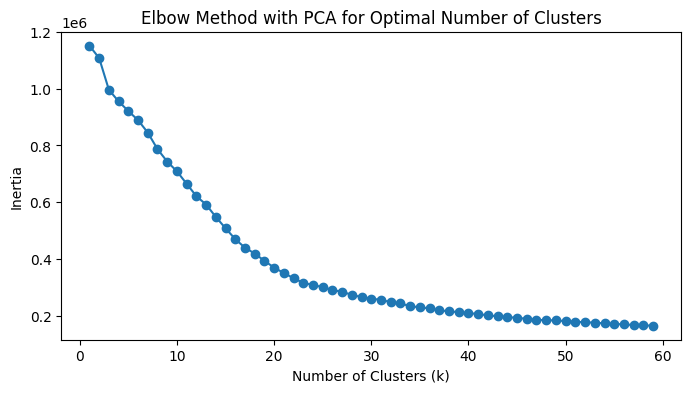

In [25]:
# First, transform the data with the preprocessor
X_transformed = preprocessor.fit_transform(df)

# Next, apply PCA on the preprocessed data to reduce dimensions (e.g., to 20 components)
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_transformed)

# Use the elbow method on the PCA-transformed data to determine the optimal number of clusters
inertia = []
k_range = range(1, 60)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method with PCA for Optimal Number of Clusters')
plt.show()

In [ ]:


numeric_features = [
    'segment_commission',
    'cost',
    'total_sales_price',
    'paid_amount',
    'meta_clicks',
    'tot_pax',
    'resultms',
    'num_legs',
    'num_rooms',
    'adults',
    'children',
    'AVB',
    'BAGFO',
    'BIKE',
    'CHANGE',
    'CHECKIN',
    'FLEX',
    'FORSNY',
    'GARANTI',
    'GOLFBAG',
    'KK',
    'RESESKYDD',
    'SKI',
    'SMS',
    'VIP',
    'VIPPREM1',
    'addon',
    'air',
    'baggage',
    'carryon',
    'climate',
    'discount',
    'fee',
    'seat_16_25',
    'seat_1_15',
    'seat_26plus',
    'upgrade',
]
categorical_features = [
    'paid',
    'cancelled',
    'mobile',
    'leg_0_origin_continent',
    'leg_0_destination_continent',
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ]
)

pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_transformed)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=20)),  # Adjust n_components based on your explained variance criteria
        ('kmeans', KMeans(n_clusters=10, random_state=42))  # Use chosen number of clusters
    ]
)

pipeline.fit(df)
df['cluster'] = pipeline.predict(df)

print(df.head())
